In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/DogBreedData

/content/drive/My Drive/DogBreedData


In [3]:
# from google.colab import files
# files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mabdullahsultan","key":"eaa392395ac16bf44df1c7f8a13f8375"}'}

In [4]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !rm kaggle.json

In [5]:
# !kaggle competitions download -c dog-breed-identification --force

 99% 684M/691M [00:08<00:00, 84.4MB/s]
100% 691M/691M [00:08<00:00, 85.3MB/s]


In [6]:
# !unzip "/content/drive/MyDrive/DogBreedData/dog-breed-identification.zip" -d "/content/drive/MyDrive/DogBreedData/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/DogBreedData/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: /content/drive/MyDrive/DogBreedData/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: /content/drive/MyDrive/DogBreedData/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: /content/drive/MyDrive/DogBreedData/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: /content/drive/MyDrive/DogBreedData/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: /content/drive/MyDrive/DogBreedData/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: /content/drive/MyDrive/DogBreedData/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: /content/drive/MyDrive/DogBreedData/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: /content/drive/MyDrive/DogBreedData/train/83fad0718581a696132c96c166472627.jpg  
  inflating: /content/drive/MyDrive/DogBreedData/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflati

# End to End Multi-class Dog Breed Classification

Think notebook is end to end Image Classification of Dog Breed.

## 1. Problem
Identifying do breed in given Image.

## 2. Data
Data obtained from Kaggle
https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation
Prediction probabilities for each dog of test image
https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features
* Data is in Image(Unstructured data) form.
* Contains 120 dog breeds (120 different classes).
* 10,000+ Images in training set.

In [7]:
# Import TensorFlow
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("TG version: ", tf.__version__)

# Check GPU avalability
print("GPU", "available(YES!!!!!)") if tf.config.list_physical_devices("GPU") else "GPU Not available"

TG version:  2.14.0


'GPU Not available'

In [8]:
## Check lables of our data
labels_csv = pd.read_csv("labels.csv")
labels_csv

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


<Axes: >

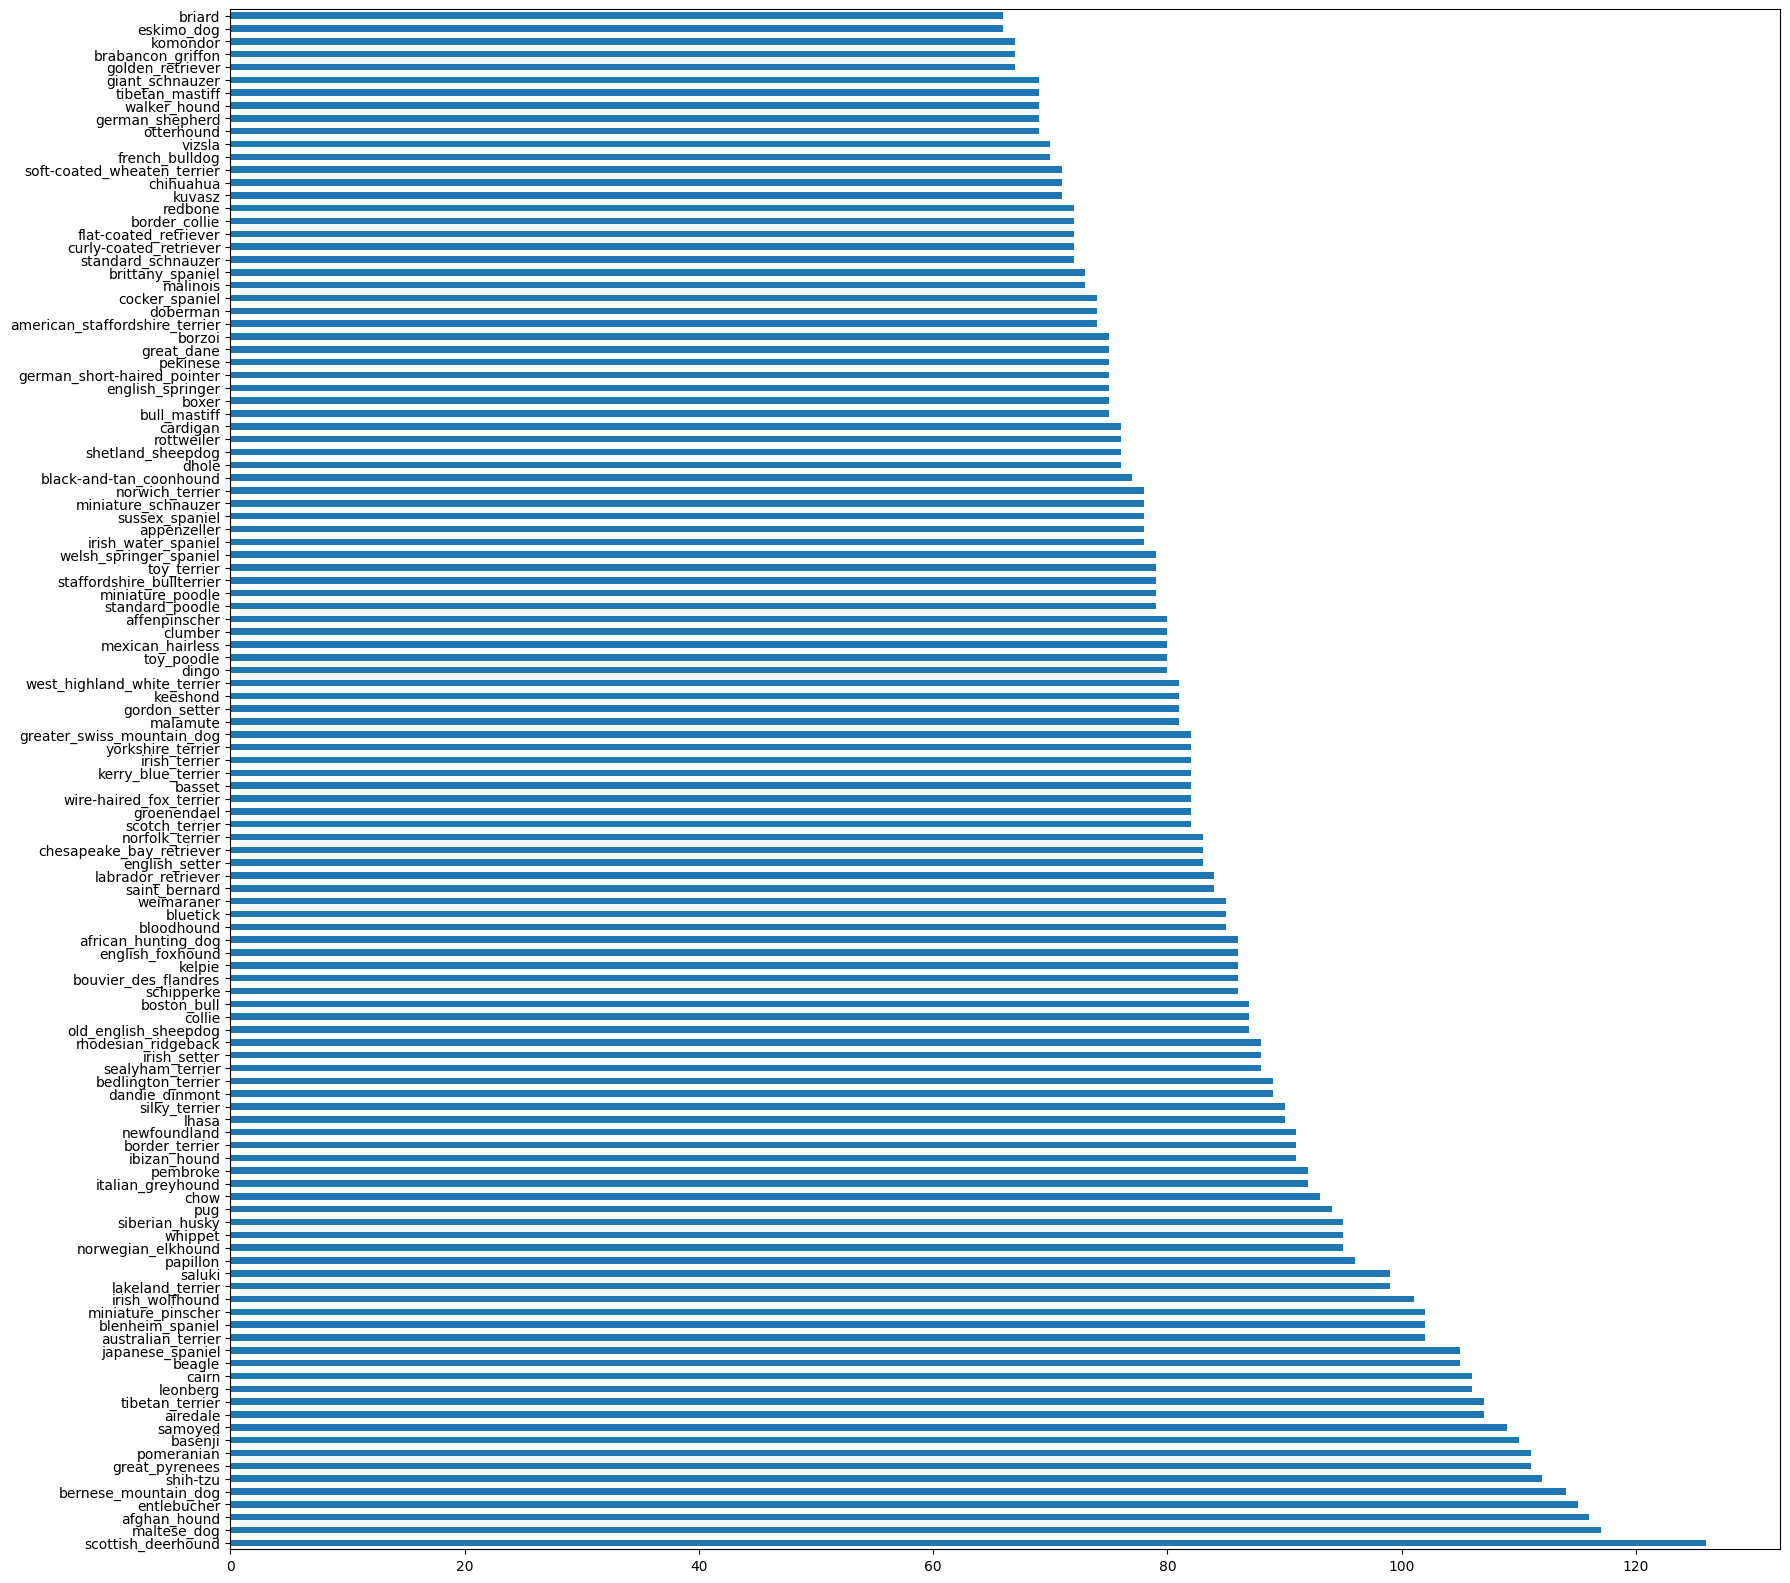

In [14]:
# How many daogs in each breed
labels_csv["breed"].value_counts().plot.barh(figsize=(20,20))

In [17]:
labels_csv.isna().value_counts

<bound method DataFrame.value_counts of           id  breed
0      False  False
1      False  False
2      False  False
3      False  False
4      False  False
...      ...    ...
10217  False  False
10218  False  False
10219  False  False
10220  False  False
10221  False  False

[10222 rows x 2 columns]>